In [1]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image


from keras import utils
from sklearn.preprocessing import LabelEncoder

# Prepare Data

In [2]:
# dir_path points towards where to find the image dataset
dir_path = "data/archive/Dataset_BUSI_with_GT/"
IMAGE_SHAPE = (224, 224)

# This is a good sample as it gives a good mix of val data
random_sample = 1


In [3]:
# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

(1578, 1578)

In [4]:
# Count the number of labels to get an idea of how balanced the dataset is
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{'benign': 891, 'malignant': 421, 'normal': 266}


In [5]:
# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 3)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

Classes are ['benign' 'malignant' 'normal']


In [6]:
# Create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

len(selected_files), len(selected_labels)

(780, 780)

In [7]:
# Split the data into testing, training and validation data
# As using a random sample = 100, the testing set is the same as used for the model.
x_train, x_tv, y_train, y_tv = train_test_split(selected_files, selected_labels, test_size=.3, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)


In [8]:
images = []
labels = []

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images.append(img_array)
    labels.append(label)

Preparing testing data


In [9]:
class_counts = [sum(col) for col in zip(*labels)]
print(f"Benign: {class_counts[0]}  Malignant: {class_counts[1]}  Normal: {class_counts[2]}")

Benign: 68  Malignant: 27  Normal: 22


In [10]:
def get_balance_iters(label):
    # Returns a value for over-sampling if balancing the data
    if label[0] == 1: # Benign
        return 1
    elif label[1] == 1: # Malignant
        return 2
    else: # Normal
        return 3

# The data augmentation to do. This applies a random horizontal flip and a random tilt.
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation((-0.3, 0.3)),
])

In [11]:
# IMPORTANT

MUBA_BALANCE = True # If true data will be oversampled to create balanced classes
AUGMENT = True # Recommended True if balancing

MIX_UP_LOOPS = 100 # How many times to create mix up images per image

In [12]:
all_lams= []
all_new_labels= []
all_mixed_up_images = []


for img, label in zip(images,labels):

    if AUGMENT:
        img = data_augmentation(img)

    if MUBA_BALANCE:
        balance_iters = get_balance_iters(label)

    for i in range(MIX_UP_LOOPS):
        for j in range(balance_iters):

            # Get index of label
            i_array = np.where(label == 1)[0]

            while len(i_array) != 3:

                # Get a new mixup image
                mixup_idx = random.randint(0, len(labels)-1)
                mixup_label = labels[mixup_idx]
                mixup_i = np.where(mixup_label == 1)[0][0]

                # Check mixup image has a different label
                if mixup_i not in i_array:
                    # Add index to i_array 
                    i_array = np.append(i_array, mixup_i)

                    #Read image
                    mixup_image = images[mixup_idx]
                    if AUGMENT:
                        mixup_image = data_augmentation(mixup_image)

                    # Mixup images
                    lam = np.random.rand()
                    new_img = lam * img + (1 - lam) * mixup_image   
                    new_label = lam * label + (1 - lam) * mixup_label
                    #Append images
                    all_lams.append(lam)
                    all_new_labels.append(new_label)
                    all_mixed_up_images.append(new_img)



# Load Models

In [13]:
simple_model = keras.models.load_model("best_simple_model_2.h5")

mixup_beta_model = keras.models.load_model("best_mixup_beta_model_2.h5")

mix_up_simple_model = keras.models.load_model("best_mixup_model_2.h5")

models = [simple_model, mixup_beta_model, mix_up_simple_model]
model_names = ["Simple Model", "Mixup Model with Beta Sample", "Simple Mixup Model"]

# Predictions and Testing

4/4 [==============================] - 19s 4s/step
Simple Model Percentage Correct = 58.97%


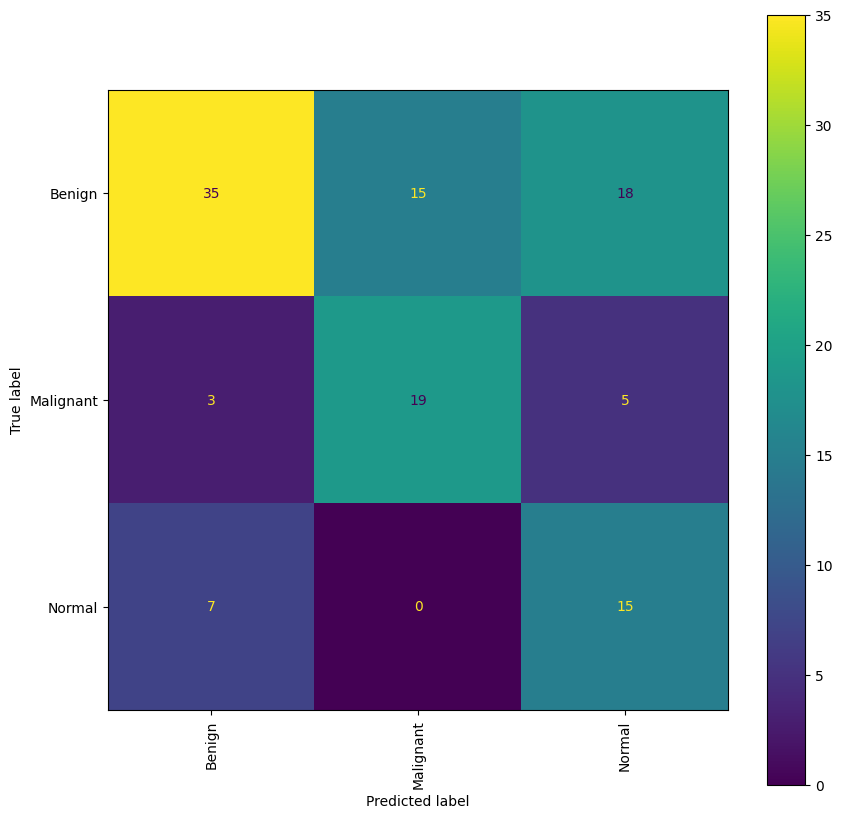

4/4 [==============================] - 20s 4s/step
Mixup Model with Beta Sample Percentage Correct = 80.34%


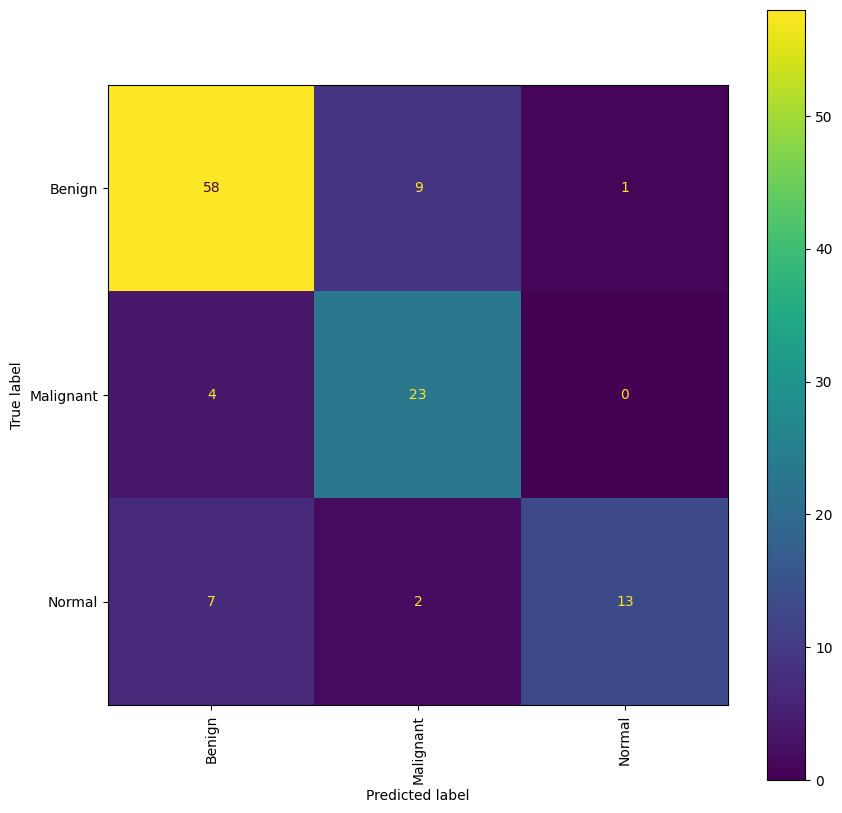

4/4 [==============================] - 22s 5s/step
Simple Mixup Model Percentage Correct = 76.92%


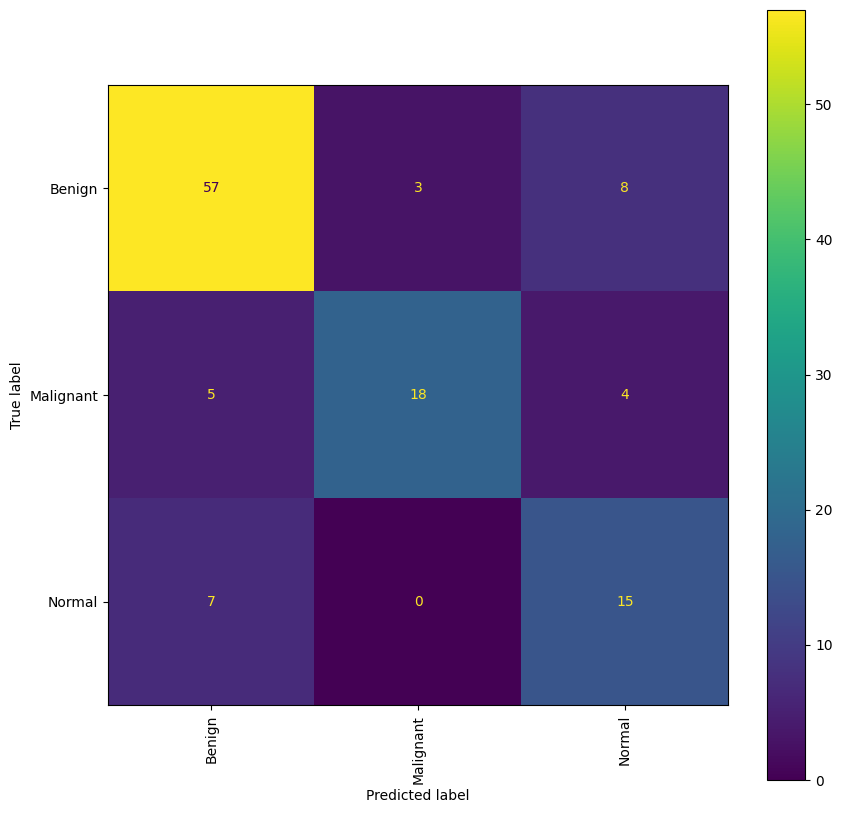

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

for model, name in zip(models, model_names):

    # Get Predictions
    result = model.predict(np.stack(images))
    pred_array = [[0,1,2][np.argmax(individual_result)] for individual_result in result]

    simple_true = 0
    for pred, label in zip(pred_array, labels):
        if np.where(label == 1)[0][0] == pred:
            simple_true += 1

    print(f"{name} Percentage Correct = {round((simple_true * 100)/len(labels),2)}%")

    y_actual = []
    for pred in y_test:
    
        if pred[0] == 1:
            y_actual.append(0)
        if pred[1] == 1:
            y_actual.append(1)
        if pred[2] == 1:
            y_actual.append(2)


    fig, ax = plt.subplots(figsize=(10, 10))
    cm = ConfusionMatrixDisplay.from_predictions(
        y_actual,
        pred_array,
        ax=ax,
        xticks_rotation=90,
        colorbar=True,
        display_labels = ["Benign","Malignant","Normal"]
    )

    plt.show()

# MUBA

In [18]:

# Benign - Malignant
bm_img = []
bm_label = []
bm_lams = []
# Benign - Normal
bn_img = []
bn_label = []
bn_lams = []
# Malignant - Normal
mn_img = []
mn_label = []
mn_lams = []

counter = 0
total = len(all_lams)
# Classes are ['benign' 'malignant' 'normal']
for image, label, lam in zip(all_mixed_up_images, all_new_labels, all_lams):
    
    if label[0] == 0: # Malignant - Normal
        mn_img.append(image)
        mn_label.append(label)

    if label[1] == 0: # Benign - Normal
        bn_img.append(image)
        bn_label.append(label)

    if label[2] == 0: # Benign - Malignant
        bm_img.append(image)
        bm_label.append(label)

    
bm_lams = [x[0] for x in bm_label] # % benign in bm pairs
bn_lams = [x[0] for x in bn_label] # % benign in bn pairs
mn_lams = [x[1] for x in mn_label] # % malignant in mn pairs

Text(0.5, 1.0, 'Malignant - Normal Pairs')

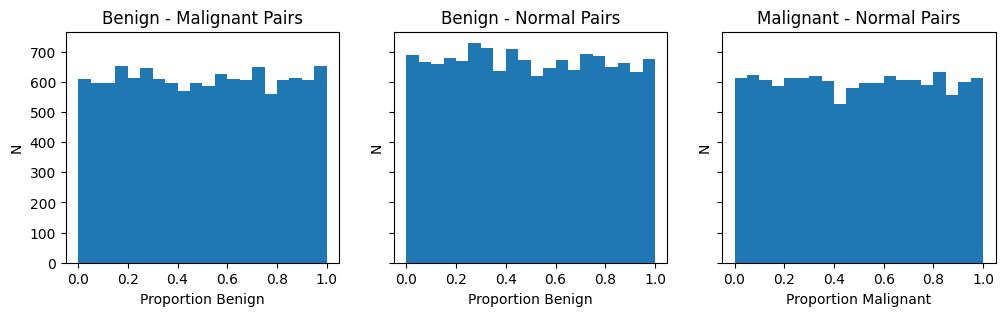

In [19]:
fig, axs = plt.subplots(1,3, figsize = (12,3), sharey = True)

axs[0].hist(bm_lams,bins=20)
axs[0].set_xlabel("Proportion Benign")
axs[0].set_ylabel("N")
axs[0].set_title("Benign - Malignant Pairs")

axs[1].hist(bn_lams,bins=20)
axs[1].set_xlabel("Proportion Benign")
axs[1].set_ylabel("N")
axs[1].set_title("Benign - Normal Pairs")

axs[2].hist(mn_lams,bins=20)
axs[2].set_xlabel("Proportion Malignant")
axs[2].set_ylabel("N")
axs[2].set_title("Malignant - Normal Pairs")

Processing MN pairs...
375/375 [==============================] - 2180s 6s/step
Processing BN pairs
419/419 [==============================] - 1630s 4s/step
Processing BM pairs
382/382 [==============================] - 1529s 4s/step


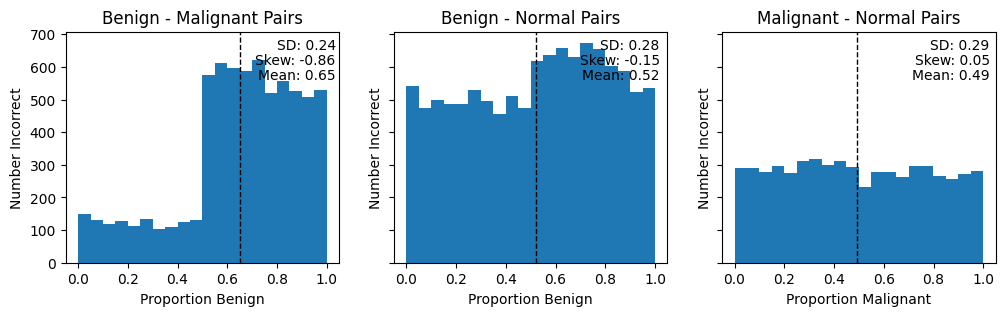

Processing MN pairs...
375/375 [==============================] - 1405s 4s/step
Processing BN pairs
419/419 [==============================] - 1494s 4s/step
Processing BM pairs
382/382 [==============================] - 1522s 4s/step


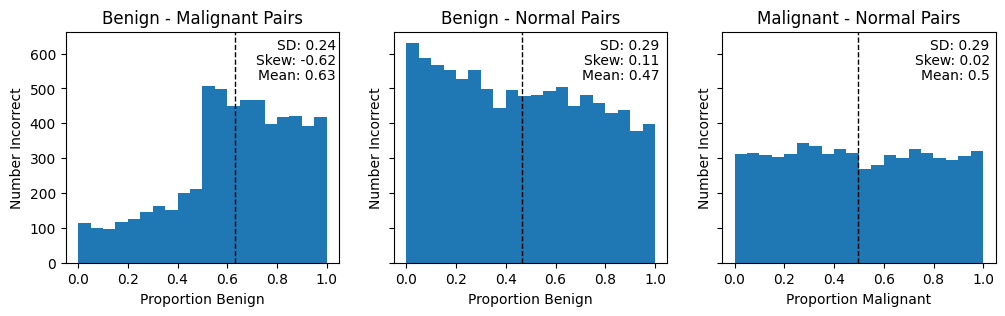

Processing MN pairs...
375/375 [==============================] - 1480s 4s/step
Processing BN pairs
419/419 [==============================] - 1473s 4s/step
Processing BM pairs
382/382 [==============================] - 1823s 5s/step


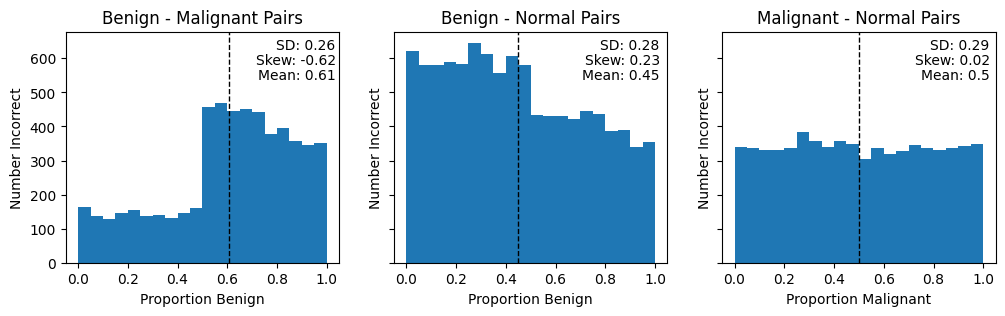

In [20]:

from scipy.stats import skew


for model, name in zip(models, model_names):

    #Initialise arrays
    incorrect_mn = []
    incorrect_bn = []
    incorrect_bm = []
    correct_mn = []
    correct_bn = []
    correct_bm = []

    print("Processing MN pairs...")

    # Make predictions
    result = model.predict(np.stack(mn_img))
    # Turn predictions into an array of 0s, 1s and 2s.
    prediction = [[0,1,2][np.argmax(individual_result)] for individual_result in result]
    #Check if prediction is correct
    for pred, label, lam in zip(prediction, mn_label, bn_lams):
        if pred != [0,1,2][np.argmax(label)]:
            incorrect_mn.append(lam)
        else:
            correct_mn.append(lam)

    #Repeat aboce for Bn and BM pairs
    print("Processing BN pairs")

    result = model.predict(np.stack(bn_img))
    prediction = [[0,1,2][np.argmax(individual_result)] for individual_result in result]
    for pred, label, lam in zip(prediction, bn_label, bn_lams):
        if pred != [0,1,2][np.argmax(label)]:
            incorrect_bn.append(lam)
        else:
            correct_bn.append(lam)

    print("Processing BM pairs")

    result = model.predict(np.stack(bm_img))
    prediction = [[0,1,2][np.argmax(individual_result)] for individual_result in result]
    for pred, label, lam in zip(prediction, bm_label, bm_lams):
        if pred != [0,1,2][np.argmax(label)]:
            incorrect_bm.append(lam)
        else:
            correct_bm.append(lam)

    fig, axs = plt.subplots(1,3, figsize = (12,3), sharey = True)

    axs[0].hist(incorrect_bm,bins=20)
    axs[0].axvline(np.mean(incorrect_bm), color='k', linestyle='dashed', linewidth=1)
    axs[0].set_xlabel("Proportion Benign")
    axs[0].set_ylabel("Number Incorrect")
    axs[0].set_title("Benign - Malignant Pairs")
    axs[0].text(0.35,0.82,f"SD: {round(np.std(incorrect_bm),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")
    axs[0].text(0.35,0.77,f"Skew: {round(skew(incorrect_bm),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")
    axs[0].text(0.35,0.72,f"Mean: {round(np.mean(incorrect_bm),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")

    axs[1].hist(incorrect_bn,bins=20)
    axs[1].axvline(np.mean(incorrect_bn), color='k', linestyle='dashed', linewidth=1)
    axs[1].set_xlabel("Proportion Benign")
    axs[1].set_ylabel("Number Incorrect")
    axs[1].set_title("Benign - Normal Pairs")
    axs[1].text(0.62,0.82,f"SD: {round(np.std(incorrect_bn),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")
    axs[1].text(0.62,0.77,f"Skew: {round(skew(incorrect_bn),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")
    axs[1].text(0.62,0.72,f"Mean: {round(np.mean(incorrect_bn),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")

    axs[2].hist(incorrect_mn,bins=20)
    axs[2].axvline(np.mean(incorrect_mn), color='k', linestyle='dashed', linewidth=1)
    axs[2].set_xlabel("Proportion Malignant")
    axs[2].set_ylabel("Number Incorrect")
    axs[2].set_title("Malignant - Normal Pairs")
    axs[2].text(0.895,0.82,f"SD: {round(np.std(incorrect_mn),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")
    axs[2].text(0.895,0.77,f"Skew: {round(skew(incorrect_mn),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")
    axs[2].text(0.895,0.72,f"Mean: {round(np.mean(incorrect_mn),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")

    plt.show()